# Permuting values to understand their impact on generated image

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import noise
from PIL import Image
import cv2
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
from art import create_net, generate_abstract_art

Generate an image:

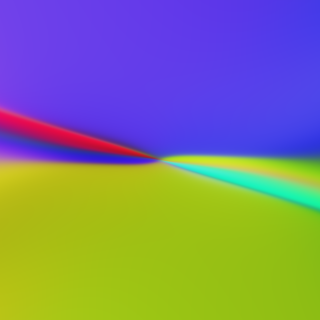

In [4]:
out = generate_abstract_art(320, 320, create_net(num_hidden_layers=4, num_neurons=8))
img = Image.fromarray(out)
img

## Playing around configs and seeing what the outputs look like

Generate a few images:

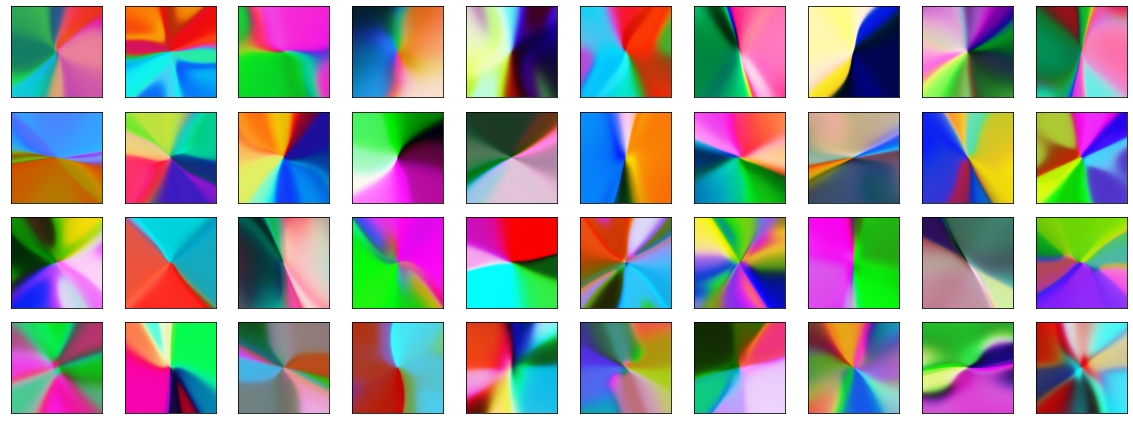

In [5]:
# Generate grid of 40 images w/ 4 hidden layers, 8 neurons each
fig, ax = plt.subplots(ncols=10, nrows=4, figsize=(16, 6))
for i in range(40):
    out = generate_abstract_art(320, 320, create_net(num_hidden_layers=4, num_neurons=8))
    img = Image.fromarray(out)
    ax[i // 10, i % 10].imshow(img)
    ax[i // 10, i % 10].xaxis.set_visible(False)
    ax[i // 10, i % 10].yaxis.set_visible(False)
plt.tight_layout()
plt.show()

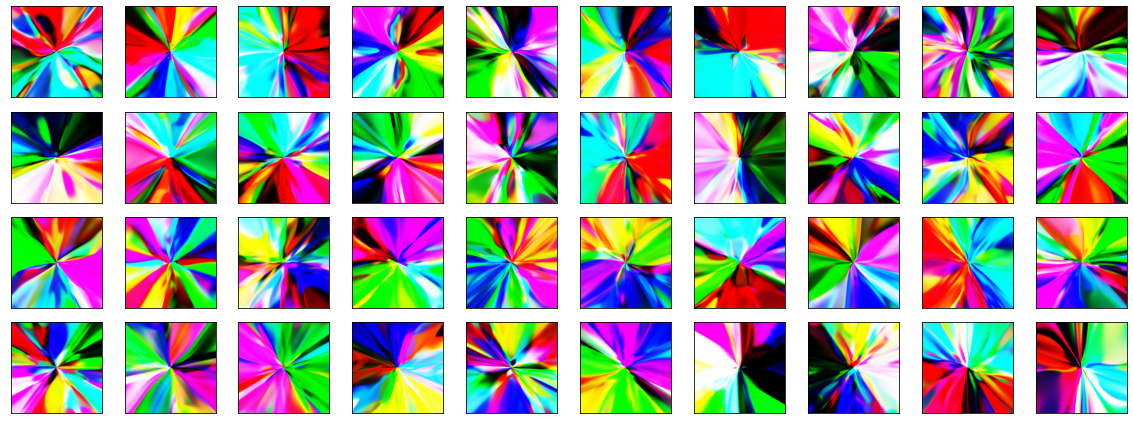

In [6]:
# Generate grid of 40 images w/ 4 hidden layers, 32 neurons each
fig, ax = plt.subplots(ncols=10, nrows=4, figsize=(16, 6))
for i in range(40):
    out = generate_abstract_art(320, 320, create_net(num_hidden_layers=4, num_neurons=32))
    img = Image.fromarray(out)
    ax[i // 10, i % 10].imshow(img)
    ax[i // 10, i % 10].xaxis.set_visible(False)
    ax[i // 10, i % 10].yaxis.set_visible(False)
plt.tight_layout()
plt.show()

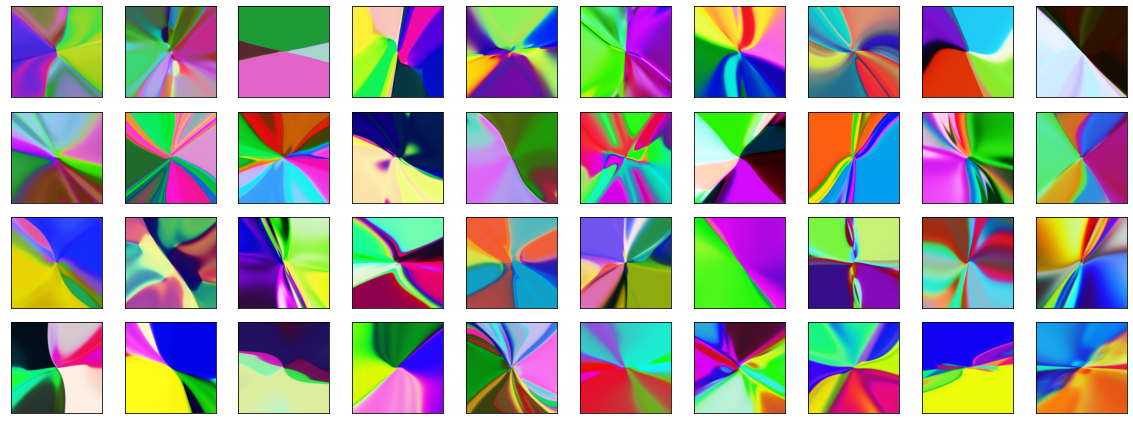

In [7]:
# Generate grid of 40 images w/ 8 hidden layers, 8 neurons each
fig, ax = plt.subplots(ncols=10, nrows=4, figsize=(16, 6))
for i in range(40):
    out = generate_abstract_art(320, 320, create_net(num_hidden_layers=8, num_neurons=8))
    img = Image.fromarray(out)
    ax[i // 10, i % 10].imshow(img)
    ax[i // 10, i % 10].xaxis.set_visible(False)
    ax[i // 10, i % 10].yaxis.set_visible(False)
plt.tight_layout()
plt.show()

In [8]:
# TODO: Check the distribution of weight magnitudes at every layer

In [9]:
# TODO: Compare derivatives of activation functions visually. 
# This probably determines where we will see interesting behavior

In [10]:
# TODO: Check the effects of batch norm?

In [11]:
# TODO: Demonstrate images from different configs

## Animate

Below tries permuting the weights w/ Gaussian noise.

In [12]:
def create_noise_weights(net, variance=0.001):
    """
    Permutes weights of the provided net.
    """
    state_dict = net.layers.state_dict()
    
    noise = {}
    
    # For each layer
    for layer, weights in state_dict.items():
        # Create noise weights w/ Gaussian noise
        # Using provided variance
        noise[layer] = torch.randn(weights.size(), dtype=torch.double) * (variance ** 0.5)
        
    return noise

In [13]:
def permute_weights(net, noise):
    state_dict = net.layers.state_dict()
        
    # For each layer
    for layer, weights in state_dict.items():
        # Apply noise
        weights += noise[layer]
        
    return net

In [42]:
cv2.__version__

'4.5.0'

In [53]:
def save_video(list_of_arrs, filename, fps=24):
    """
    Make sure that `file` ends in `.mp4`.
    """

    size = list_of_arrs[0].shape[0:2]
    writer = cv2.VideoWriter(
        filename, cv2.VideoWriter_fourcc(*"H264"),fps, size
    )

    for frame in list_of_arrs:
        writer.write(frame)
    writer.release()

In [23]:
net = create_net(num_hidden_layers=4, num_neurons=8)
frames = []

for i in range(200):
    out = generate_abstract_art(320, 320, net)
    
    # Save np array to list because we will save to video using OpenCV
    frames.append(out)
    
    # Permute weights!
    noise = create_noise_weights(net, variance=0.0001)
    net = permute_weights(net=net, noise=noise)

In [54]:
# Save to MP4
save_video(frames, "../output/permute-weights-gaussian.mp4", 24)

<video controls src="../output/permute-weights-gaussian.mp4"></video>

In this case, we permuted the weights w/ Gaussian noise at every step. The image does not vary much from its initial configuration, as we are just adding noise centered at mean 0.

Generating the noise arrays once and applying them repeatedly over time results in the following:

In [55]:
net = create_net(num_hidden_layers=4, num_neurons=8)
frames = []
noise = create_noise_weights(net, variance=0.0001)

for i in range(800):
    out = generate_abstract_art(320, 320, net)
    
    # Save np array to list because we will save to video using OpenCV
    frames.append(out)
    
    # Permute weights!
    net = permute_weights(net=net, noise=noise)

In [56]:
# Save to MP4
save_video(frames, "../output/permute-weights-gaussian-continuous.mp4", 24)

<video controls src="../output/permute-weights-gaussian-continuous.mp4"></video>

This produces a smooth animation which is pleasing to look at and gives some sense of structure. The rotation about the centre is especially fascinating to see, as a result from forwarding values through a series of `tanh`s.

However, applying the same weight permutations at every step causes the weight magnitudes to increase / decrease in a single direction, causing the output of each layer to the tanh activation to stray further from the centre region about 0. After a while, the splotches of colour transition into well-defined zones of colour with sharp boundaries, and become brighter as the RGB values tend to 0 or 255. (TODO to verify!) Due to the gradient of tanh being near zero beyond the middle range, changes in patterns plateau to a halt. Occasionally we get to see a segment of colour break out into a different colour, but for all intents and purposes, the generated image becomes less interesting over time.

The remedy would be to stop the network from leaving the interesting regime of `tanh`. At this point in time, I can think of a few ways:
+ Reverse the magnitudes of the noise to backtrack in the opposite direction
+ Smoothly adjust the noise while watching the weights' magnitudes
+ Apply batchnorm

Now try permuting input instead using Gaussian noise. This has the useful property of exploring the latent space. 

In [62]:
def create_input(img_width, img_height):
    """
    Creates the input for the generative net. 
    Outputs numpy array w/ shape (img_width * img_height, 2)
    """
    # Create vectors of xs and ys   
    xs = np.linspace(start=-1, stop=1, num=img_width)
    ys = np.linspace(start=-1, stop=1, num=img_height)
    
    # Use np.meshgrid to create a mesh grid
    xv, yv = np.meshgrid(xs, ys)
    input_arr = np.stack((xv, yv), axis=2)
    input_arr = input_arr.reshape(img_width * img_height, 2)
    return input_arr

In [57]:
def create_input_noise(img_width, img_height, variance):
    """
    Creates the input for the generative net. 
    Outputs numpy array w/ shape (img_width * img_height, 2)
    """    
    noise = torch.zeros(img_width * img_height, 2, dtype=torch.double)
    
    # Preserve the same shape, and apply one noise across it
    # This only transposes, which isn't fun
    # i.e. only vibrates the image about the centre!
    # noise += torch.randn((1,), dtype=torch.double) * (variance ** 0.5)
    
    # This breaks local structure but is more interesting
    noise += torch.randn(img_width * img_height, 2, dtype=torch.double) * (variance ** 0.5)
    return noise

In [63]:
def generate_abstract_art_noisy(img_width, img_height, net, variance, prior_input=None):
    if prior_input is None:
        # Create input to net
        net_input = torch.tensor(create_input(img_width, img_height)).double()
        net_input += create_input_noise(img_width, img_height, variance)
    else:
        net_input = prior_input + create_input_noise(img_width, img_height, variance)
    
    # Run input through net
    net_output = net(net_input).detach().numpy()
    
    # Reshape into (x, y, 3) for plotting
    net_output = net_output.reshape(320, 320, 3)
    
    # Re-format to color output
    # Scale to range 0 to 255, and set type to int
    net_output = (net_output * 255).astype(np.uint8)
    return net_output, net_input

In [64]:
net = create_net(num_hidden_layers=4, num_neurons=32)
frames = []
prior_input = None
for i in range(300):
    out, prior_input = generate_abstract_art_noisy(320, 320, net, variance=0.01, prior_input=prior_input)
    
    # Save np array to list because we will save to video using OpenCV
    frames.append(out)
    
    # Permute weights!
    # net = permute_weights(net=net, variance=0.0001)

In [65]:
# Save to MP4
save_video(frames, "../output/permute-input-gaussian.mp4", 24)

<video controls src="../output/permute-input-gaussian.mp4"></video>

Observations are:
+ Applying one random variable to the whole input means it only transposes. Not interesting. Earlier versions saw the image generated basically vibrating about the centre due to the noise weights not being cumulatively added to the weights.
+ Allowing each input pixel to vary randomly causes the colours to go wild and turn into a saturated snow crash, as the local structure is no longer obeyed. 

Both are not interesting!

### Perlin Noise

Trying Perlin noise to permute the weights instead.

In [14]:
noise.pnoise2(x, y, octaves=1, persistence=0.5, lacunarity=2.0, repeatx=1024, repeaty=1024, base=0.0)

NameError: name 'x' is not defined

Permuting input layer.

In [271]:
# TODO

Permuting weights.

In [ ]:
# TODO

### Zooming to reveal fractal structure instead?

This would be modifying the inputs, have nothing to do w/ the weights.

## Export model

In [157]:
# TODO: Export the model, see if can run 60FPS as screensaver!
# Get this to be able to be shown as a public demo